<a href="https://colab.research.google.com/github/Bmartins25/Mineracao_de_dados_and_LLM_UFMG/blob/main/TP2_Disciplina_Mineracao_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Alunos: Bruno Bartolomeu e Carlos Large - Mineração de dados UFMG

Nome do Dataset: Olimpíadas 2024 vs PIB

Origem do Dataset: https://www.kaggle.com/datasets/ernestitus/2024-olympics-medals-vs-gdp

Características do Dataset: 10 Colunas | 7 Colunas numéricas e 3 Colunas texto



------


# Segue abaixo TP1 - FASE **2**



# **Data Preparation**

**Objetivo: Garantir que os dados estejam prontos para modelagem.**

* Limpeza de Dados:

   * Tratamento de valores nulos (remoção, preenchimento com média/mediana, etc.).
   * Remoção de duplicatas.

* Transformação de Dados:
   - Normalização das variáveis numéricas para evitar escalas desiguais.
   - Criação de colunas binárias para medalhas (ex.: país ganhou ou não medalha).
* Seleção de Features:

   - Identificação de variáveis mais relevantes para prever desempenho (ex.: medalhas totais).
   - Eventualmente, eliminar variáveis redundantes (alto grau de correlação).

* Divisão dos Dados:

  - Separação em treino e teste (70%-30% ou 80%-20%), se aplicável para modelagem preditiva.


# **Data Understanding**

**Objetivo: Explorar os dados para compreender sua estrutura, padrões e características específicas.**


* Exploração Inicial:

   * Leitura dos dados e exibição das primeiras linhas para entender a estrutura.
   * Estatísticas descritivas (média, mediana, desvio padrão, valores mínimos e máximos).
   * Identificação de valores ausentes e tipos de dados (numéricos, categóricos, etc.).

* Análise Visual:

  * Histogramas para variáveis numéricas (gold, silver, bronze, etc.).
  * Boxplots para identificar outliers.
 * Gráficos de dispersão para entender relações entre PIB (gdp), população e medalhas.

* Insights sobre os Dados:

   * Identificação de possíveis clusters de países com desempenho semelhante.
   * Análise de correlação entre medalhas e variáveis econômicas ou demográficas.

Link para conversa com LLM: https://chatgpt.com/c/67352111-5de0-8009-9581-008542076e6e

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.cluster import DBSCAN
from itertools import combinations

In [ ]:
# Carregar a base de dados com delimitador correto
data = pd.read_csv('Olympics_games_2024.csv', delimiter=';')

In [ ]:
# Preparo dos dados para PCA e K-Means (excluindo colunas categóricas)
numeric_data = data[['gold', 'silver', 'bronze', 'total', 'gdp', 'population']].copy()

In [ ]:
# Remoção de dados nulos - Limpeza dos dados
numeric_data.dropna(inplace=True)

In [ ]:
# Normalização dos dados numéricos
scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(numeric_data)

# **Matriz de Correlação**

In [ ]:
# Cálculo da matriz de correlação para encontrar associações entre as variáveis
correlation_matrix = pd.DataFrame(numeric_data_scaled, columns=numeric_data.columns).corr()
print("Correlation Matrix of Numeric Olympic Data:")
print(correlation_matrix)
plt.show()

Correlation Matrix of Numeric Olympic Data:
                gold    silver    bronze     total       gdp  population
gold        1.000000  0.910676  0.880333  0.960874  0.331392    0.445283
silver      0.910676  1.000000  0.939877  0.979703  0.305993    0.347893
bronze      0.880333  0.939877  1.000000  0.968294  0.376044    0.347596
total       0.960874  0.979703  0.968294  1.000000  0.347942    0.393278
gdp         0.331392  0.305993  0.376044  0.347942  1.000000   -0.112182
population  0.445283  0.347893  0.347596  0.393278 -0.112182    1.000000


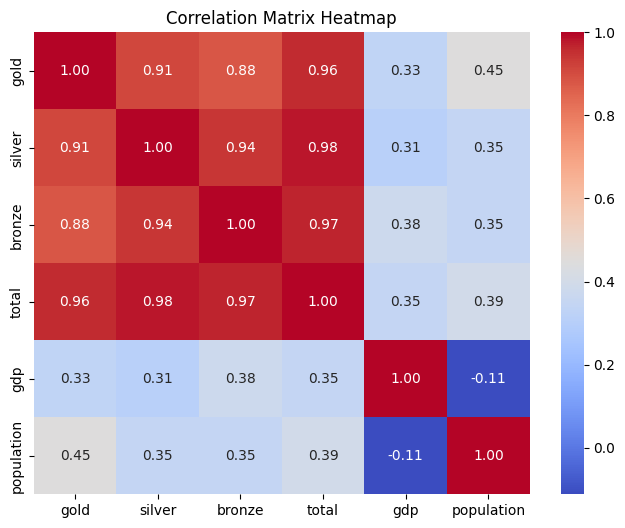

In [ ]:
# Gráfico da matriz de correlação (Heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

A matriz de correlação dos dados numéricos foi exibida.

Essa análise mostra associações entre variáveis como gold, silver, bronze, total, gdp e population. Isso nos ajuda a identificar padrões e relações fortes, como entre o número total de medalhas (total) e as medalhas específicas (gold, silver, bronze).

In [ ]:
# Binarização dos dados de medalhas para criar uma estrutura transacional
binary_data = data[['gold', 'silver', 'bronze']].applymap(lambda x: 1 if x > 0 else 0)

<ipython-input-163-244bce084cbd>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_data = data[['gold', 'silver', 'bronze']].applymap(lambda x: 1 if x > 0 else 0)


# Utilizando o algoritmo de associação **ECLAT**

In [ ]:
# Função para calcular frequências de conjuntos de itens usando ECLAT
def eclat(data, min_support=0.3):
    n_transactions = len(data)
    itemsets = {}

    # Conjuntos de 1 item (unitemsets)
    for column in data.columns:
        support = data[column].sum() / n_transactions
        if support >= min_support:
            itemsets[frozenset([column])] = support

    # Conjuntos de itens maiores (iterativo)
    k = 2
    while True:
        new_itemsets = {}
        previous_itemsets = list(itemsets.keys())
        for i in range(len(previous_itemsets)):
            for j in range(i + 1, len(previous_itemsets)):
                candidate = previous_itemsets[i] | previous_itemsets[j]
                if len(candidate) == k:
                    support = (data[list(candidate)].sum(axis=1) == k).mean()
                    if support >= min_support:
                        new_itemsets[candidate] = support
        if not new_itemsets:
            break
        itemsets.update(new_itemsets)
        k += 1

    return itemsets

In [ ]:
# Executar o ECLAT com suporte mínimo de 30%
min_support = 0.3
frequent_itemsets = eclat(binary_data, min_support=min_support)

In [ ]:
# Exibir os resultados
frequent_itemsets_sorted = sorted(frequent_itemsets.items(), key=lambda x: -x[1])
print("Frequent Itemsets (ECLAT):")
for itemset, support in frequent_itemsets_sorted:
    print(f"Itemset: {set(itemset)}, Support: {support:.2f}")

Frequent Itemsets (ECLAT):
Itemset: {'bronze'}, Support: 0.86
Itemset: {'silver'}, Support: 0.72
Itemset: {'gold'}, Support: 0.70
Itemset: {'bronze', 'gold'}, Support: 0.61
Itemset: {'bronze', 'silver'}, Support: 0.60
Itemset: {'gold', 'silver'}, Support: 0.56
Itemset: {'bronze', 'gold', 'silver'}, Support: 0.49


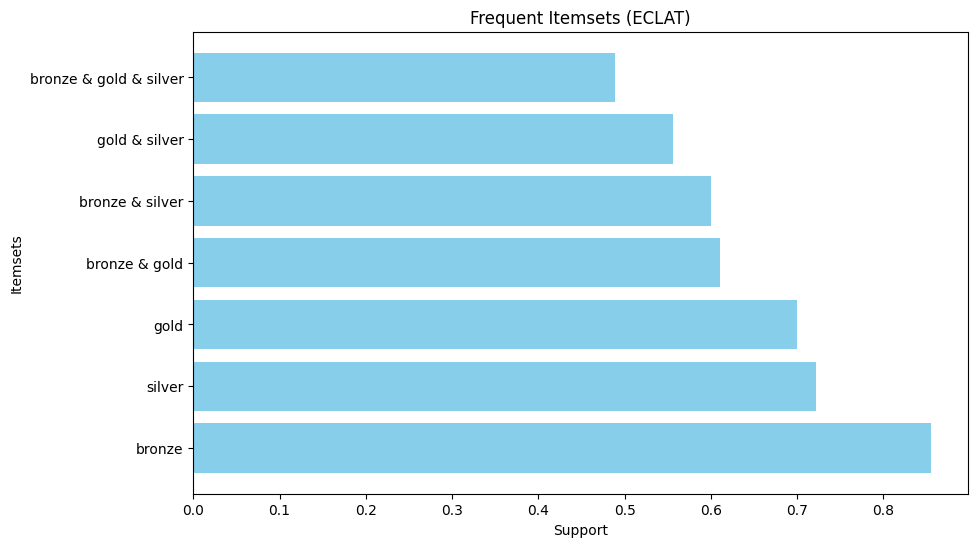

In [ ]:
# Visualização dos resultados do ECLAT
plt.figure(figsize=(10, 6))
items = [' & '.join(list(item)) for item, _ in frequent_itemsets_sorted]
supports = [support for _, support in frequent_itemsets_sorted]
plt.barh(items, supports, color='skyblue')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Frequent Itemsets (ECLAT)')
plt.show()

A execução do algoritmo ECLAT foi concluída, e os resultados foram exibidos:

* Os conjuntos frequentes foram listados com seus respectivos suportes.
* Um gráfico de barras horizontal foi gerado para visualizar os suportes dos conjuntos mais frequentes.

Os conjuntos frequentes mostram associações como países que ganham medalhas de bronze terem alta probabilidade de ganhar outras medalhas.

# **Utilizando PCA para reduzir a dimensionalidade a 2 componentes**

In [ ]:
# Aplicando PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numeric_data)

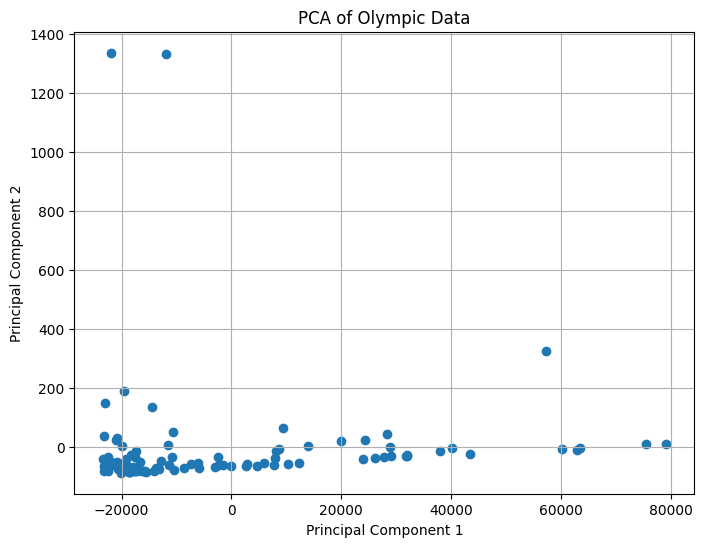

In [ ]:
# Gráfico do resultado do PCA
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('PCA of Olympic Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

A imagem mostra os dois primeiros componentes principais:

Eixos do gráfico:

* O eixo X representa o Primeiro Componente Principal, que captura a maior parte da variância dos dados.

* O eixo Y representa o Segundo Componente Principal, que captura a segunda maior parte da variância restante.
Distribuição dos dados:

A maioria dos pontos está concentrada próximo à origem (0,0), indicando que os dados são menos variáveis em relação aos primeiros dois componentes principais.

Alguns pontos estão muito distantes da origem, indicando possíveis outliers ou observações que têm um impacto significativo na variância capturada pelos componentes.

A PCA foi utilizada para identificar padrões ou tendências nos dados olímpicos, reduzindo sua complexidade ao focar apenas nos componentes principais.

**Observação importante:** Pontos mais afastados (outliers) podem ser atletas, países ou eventos com características excepcionais.

# **Aplicação do K-means para Clusterização**

In [ ]:
# Aplicar KMeans clustering com 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(numeric_data)

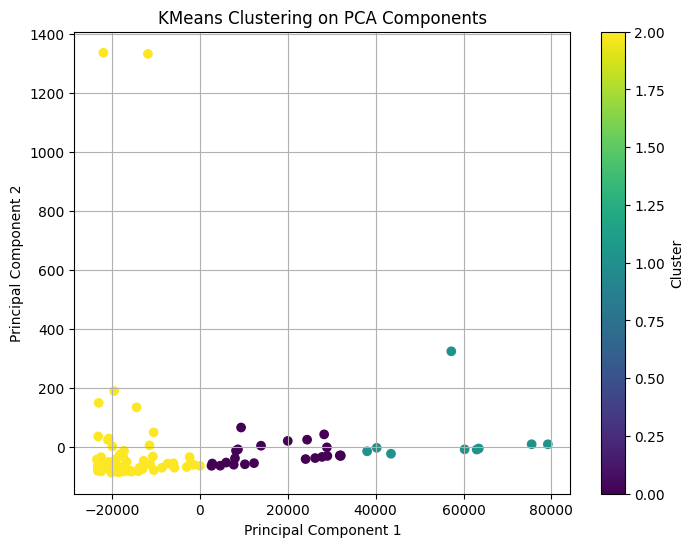

In [ ]:

# Gráfico do resultado da clusterização KMeans nos componentes do PCA
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis')
plt.title('KMeans Clustering on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Aplicação do DBSCAN para **Clusterização**

In [ ]:
# Aplicação do DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
clusters = dbscan.fit_predict(numeric_data_scaled)


In [ ]:
# Adicionar os rótulos dos clusters ao DataFrame original
data['DBSCAN_Cluster'] = clusters

In [ ]:
# Criar um DataFrame para visualização
visualization_df = pd.DataFrame(numeric_data_scaled, columns=numeric_data.columns)
visualization_df['DBSCAN_Cluster'] = clusters
visualization_df['Country'] = data['country']

In [ ]:
# Reordenar colunas para melhor visualização
visualization_df = visualization_df[['Country', 'DBSCAN_Cluster', 'gold', 'silver', 'bronze', 'total', 'gdp', 'population']]


In [ ]:
# Contagem de elementos em cada cluster
cluster_counts = data['DBSCAN_Cluster'].value_counts()
print("Contagem de elementos por cluster:")
print(cluster_counts)


Contagem de elementos por cluster:
DBSCAN_Cluster
 0    84
-1     6
Name: count, dtype: int64


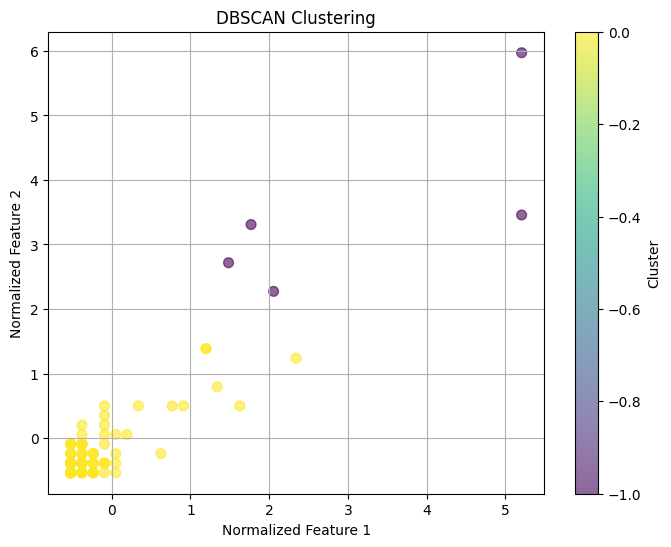

In [ ]:
# Visualização do clustering
plt.figure(figsize=(8, 6))
plt.scatter(
    numeric_data_scaled[:, 0], numeric_data_scaled[:, 1],
    c=clusters, cmap='viridis', s=50, alpha=0.6
)
plt.title('DBSCAN Clustering')
plt.xlabel('Normalized Feature 1')
plt.ylabel('Normalized Feature 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [ ]:
# Exibir os resultados completos
print("Resultados da análise DBSCAN:")
print(data[['country', 'DBSCAN_Cluster']])

Resultados da análise DBSCAN:
          country  DBSCAN_Cluster
0   United States              -1
1           China              -1
2           Japan               0
3       Australia              -1
4          France              -1
..            ...             ...
85           Peru               0
86          Qatar               0
87      Singapore               0
88       Slovakia               0
89         Zambia               0

[90 rows x 2 columns]


In [ ]:
# Reordenar colunas para melhor visualização
visualization_df = visualization_df[['Country', 'DBSCAN_Cluster', 'gold', 'silver', 'bronze', 'total', 'gdp', 'population']]



In [ ]:
# Exibir o DataFrame final
print("DBSCAN Clustering Visualization:")
print(visualization_df)

DBSCAN Clustering Visualization:
          Country  DBSCAN_Cluster      gold    silver    bronze     total  \
0   United States              -1  5.208659  5.971316  5.762587  5.818801   
1           China              -1  5.208659  3.456559  3.014459  4.039610   
2           Japan               0  2.343260  1.237655  1.335047  1.701245   
3       Australia              -1  2.056720  2.273143  1.793069  2.107918   
4          France              -1  1.770180  3.308632  2.709112  2.667092   
..            ...             ...       ...       ...       ...       ...   
85           Peru               0 -0.522139 -0.537468 -0.497038 -0.535452   
86          Qatar               0 -0.522139 -0.537468 -0.497038 -0.535452   
87      Singapore               0 -0.522139 -0.537468 -0.497038 -0.535452   
88       Slovakia               0 -0.522139 -0.537468 -0.497038 -0.535452   
89         Zambia               0 -0.522139 -0.537468 -0.497038 -0.535452   

         gdp  population  
0   2.252153   

In [ ]:
# Preparo dos dados para análise de regressão
X = data[['gdp', 'population']]
y = data['total']

In [ ]:
# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# **Aplicação de Regressão Linear e Randon Forest de forma preditiva**
Prever a quantidade de medalhas com base em variáveis econômicas e populacionais:

Regressão Linear - Algoritmo de Machine Learning

   * Prever o total de medalhas com base em PIB e população.

In [ ]:
# Aplicar Regressão Linear
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

Randon Forest - Algoritmo de Machine Learning

   * Capturar interações mais complexas entre as variáveis para prever o número de medalhas.

In [ ]:
# Aplicar Random Forest Regression
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [ ]:
# Avaliação dos modelos
linear_mse = mean_squared_error(y_test, y_pred_linear)
linear_r2 = r2_score(y_test, y_pred_linear)

rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

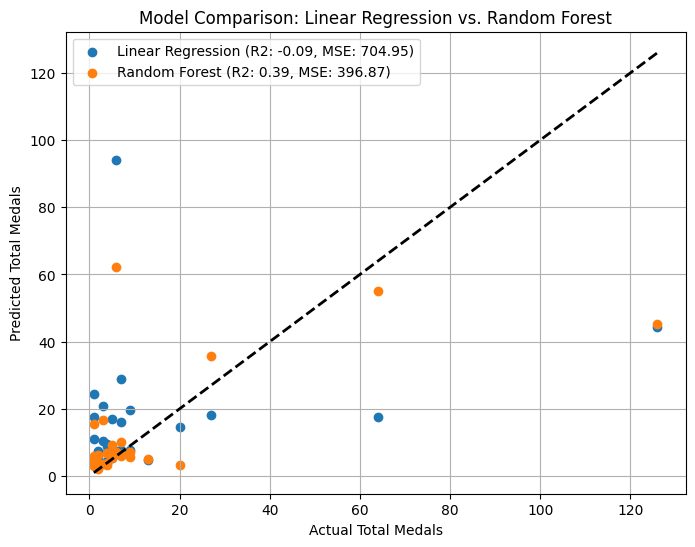

In [ ]:
# Gráfico de comparação das previsões dos modelos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linear, label=f'Linear Regression (R2: {linear_r2:.2f}, MSE: {linear_mse:.2f})')
plt.scatter(y_test, y_pred_rf, label=f'Random Forest (R2: {rf_r2:.2f}, MSE: {rf_mse:.2f})')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Total Medals')
plt.ylabel('Predicted Total Medals')
plt.legend()
plt.title('Model Comparison: Linear Regression vs. Random Forest')
plt.grid(True)
plt.show()

# **Métricas de avaliação dos modelos**

Regressão Linear e Random Forest, duas métricas para avaliar o desempenho: R² (coeficiente de determinação) e MSE (erro quadrático médio).

* Linear Regression:

   * R²: -0.09 (valor negativo indica que o modelo está performando pior do que uma média constante dos dados).
   * MSE: 704.95 (quanto menor, melhor; aqui indica um alto erro médio).

* Random Forest:

   * R²: 0.39 (valor positivo, indicando que o modelo explica 39% da variância dos dados, sendo muito melhor que a regressão linear).

   * MSE: 396.87 (mais baixo que o da regressão linear, indicando melhor desempenho no erro médio).

<br>

Conclusão: O modelo de Random Forest teve um desempenho significativamente melhor do que o modelo de Regressão Linear, tanto no R² quanto no MSE.

-------------------------------------------------------------------------------

# **Considerações da LLM e da Dupla Acadêmica**

* De acordo com a base de dados utilizado, os resultados sugerem que a Random Forest é mais eficaz para prever a quantidade de medalhas com base nas variáveis econômicas e populacionais, o DBSCAN melhor para clusterização enquanto o K-Means e o PCA ajudam na análise exploratória dos padrões na base.


<br>
<br>


* Essas conclusões estão alinhadas com a dupla acadêmica (Bruno e Carlos) e com as observações obtidas a partir dos dados e gráficos gerados no notebook, reforçando a consistência das análises realizadas.

# Segue abaixo TP1 - FASE **3**

# **Modeling**

* Aplicar os Algoritmos: Executados e explicados acima.

* Comparar Desempenho: Comparações realizadas acima no notebook com nomes, formas e gráficos dos algoritmos utilizados.

* Justificar Escolhas: As opções utilizadas foram passadas pela LLM porém, de acordo com a nossa conclusão, os resultados sugerem que a Random Forest é mais eficaz para prever a quantidade de medalhas com base nas variáveis econômicas e populacionais, o DBSCAN melhor para clusterização enquanto o K-Means e o PCA ajudam na análise exploratória dos padrões na base.

* Link para conversa com LLM: https://chatgpt.com/c/67352111-5de0-8009-9581-008542076e6e

# **Evaluation**

* Análise de Resultados: Executados e explicados acima.

* Avaliação dos Algoritmos: Criticar o desempenho do(s) algoritmo(s) em termos de eficiência e precisão.

* Considerações Finais: Reflexão sobre os desafios enfrentados, o que funcionou bem e o que poderia ser melhorado.

* Link para conversa com LLM: https://chatgpt.com/c/67352111-5de0-8009-9581-008542076e6e